ResNet50 model 

In [1]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime
import numpy as np 
import pandas as pd 
import torch 
from PIL import Image
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from torchvision.models.resnet import resnet50
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision import datasets 
from torchvision.transforms import ToTensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
with torch.no_grad():
    torch.cuda.empty_cache()

In [2]:
import art
from art import attacks 
from art.attacks.evasion import FastGradientMethod, DeepFool, CarliniL0Method, BasicIterativeMethod
from art.estimators.classification import PyTorchClassifier
from art.defences.trainer import AdversarialTrainer

In [3]:
today = "hallo" 
%store today 


# other notebook 
%store -r today 
today

Stored 'today' (str)


'hallo'

In [4]:
device

device(type='cuda')

In [5]:
# defining hyperparameters  
epochs = 30  #the nn will train 29 times 
learning_rate = 0.0001 #how much the weight will be updated each time 
batch_size = 64 
classes = 43 
img_size = 32
random_seed = 42

In [6]:
transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                        (0.2724, 0.2608, 0.2669))
])

In [7]:
test_dataset = torchvision.datasets.GTSRB(
    root='./data', split = 'test', transform=transforms, download=True)

# train loader 
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size
, shuffle=False, num_workers=2)

In [8]:
def get_train_valid_loader(
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           num_workers=2):

    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg


    # load the dataset
    global base_dataset
    base_dataset = torchvision.datasets.GTSRB(
    root='./data', split = 'train', transform=transforms, download=True)

    # TODO
    split_datasets = torch.utils.data.random_split(base_dataset, [0.20,0.8])
    global val_dataset, train_dataset
    val_dataset = split_datasets[0]
    train_dataset = split_datasets[1]
    

    global num_train 
    num_train= len(train_dataset)
    indices = list(range(num_train))
    global split 
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)


    #train_idx, valid_idx = indices[split:], indices[:split]
    #train_sampler = SubsetRandomSampler(train_idx)
    #valid_sampler = SubsetRandomSampler(valid_idx)


    global train_loader 
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = train_sampler
    )
    global valid_loader 
    valid_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = valid_sampler
    )

    return train_loader, valid_loader

print(get_train_valid_loader(batch_size = 64, augment = True, random_seed = 1))


(<torch.utils.data.dataloader.DataLoader object at 0x7f34bbe0fa30>, <torch.utils.data.dataloader.DataLoader object at 0x7f34a97e1a60>)


In [9]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [10]:
def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [11]:
# train function

def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat= model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [12]:
# validation function, without a learning step (backward pass)

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat= model(X)    # predicted
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [13]:
# training function
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [14]:
model = resnet50(pretrained=False)
model.fc = torch.nn.Linear(2048,43)
model.conv1 = torch.nn.Conv2d(3,64,kernel_size=5,stride=1)

model = model.to(device)

In [15]:

torch.manual_seed(random_seed)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


23:04:17 --- Epoch: 0	Train loss: 2.5749	Valid loss: 1.5447	Train accuracy: 58.67	Valid accuracy: 53.96
23:04:33 --- Epoch: 1	Train loss: 0.9801	Valid loss: 0.6248	Train accuracy: 87.52	Valid accuracy: 80.87
23:04:49 --- Epoch: 2	Train loss: 0.3197	Valid loss: 0.3487	Train accuracy: 95.96	Valid accuracy: 89.34
23:05:05 --- Epoch: 3	Train loss: 0.0930	Valid loss: 0.2538	Train accuracy: 97.96	Valid accuracy: 92.38
23:05:21 --- Epoch: 4	Train loss: 0.0484	Valid loss: 0.2794	Train accuracy: 97.43	Valid accuracy: 91.39
23:05:37 --- Epoch: 5	Train loss: 0.0779	Valid loss: 0.3201	Train accuracy: 96.40	Valid accuracy: 90.50
23:05:53 --- Epoch: 6	Train loss: 0.0780	Valid loss: 0.2331	Train accuracy: 97.68	Valid accuracy: 93.49
23:06:09 --- Epoch: 7	Train loss: 0.0647	Valid loss: 0.2742	Train accuracy: 96.74	Valid accuracy: 92.72
23:06:25 --- Epoch: 8	Train loss: 0.0545	Valid loss: 0.1918	Train accuracy: 98.35	Valid accuracy: 94.54
23:06:42 --- Epoch: 9	Train loss: 0.0583	Valid loss: 0.2024	Trai

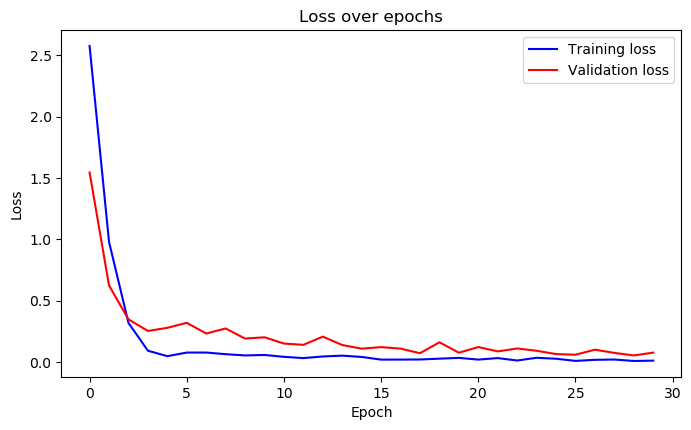

In [16]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device)

In [ ]:
torch.save(model.state_dict(), "resnet50.pt")

# CW attack 

In [17]:
# We wrap our model in a PyTorchClassifier, which ART knows how to use
classifier = PyTorchClassifier(
    # model=WrappedModel(),
    model=model,
    clip_values=(0.0, 1.0),  # The adversarial sample tensor values will be within these values
    loss=criterion,  # defined above
    optimizer=optimizer,  # defined above
    input_shape=(3, 32, 32),
    nb_classes=43,
    device_type="cpu",
)


In [ ]:
device = "cpu"
model.to(device)

In [20]:
from torch.utils.data import ConcatDataset

In [21]:
combined_gtsrb = ConcatDataset([base_dataset, test_dataset])

In [22]:
plot_output = []
iterations = 10

# For each number of iterations [1, 2, ..., 10], calculate the success rate/accuracy -> these are the X and Y coordinates of the graph
tp = 0
tn = 0
fp = 0 
fn = 0
total_img = 0
total_14 = 0
for i in range(iterations):
    # Define an attack that only runs until this max iteration
    attack = BasicIterativeMethod(estimator=classifier, max_iter=i, batch_size=1, verbose = False)
    success_rates = []
    for j, (image, true_label) in enumerate(combined_gtsrb):
        total_img += 1 
        # image is an image, given as a tensor with shape [3, 32, 32]
        # true_label is a simple int
        # Add batch dimension
        image = torch.unsqueeze(image, dim=0)  # shape == [1, 3, 32, 32]
        # Omvormen naar numpy array
        image_numpy = image.numpy()
        true_label_numpy = np.array([true_label])
        # Genereer adversarial sample
        X_adv = attack.generate(image_numpy)  # shape == [1, 3, 32, 32]
        # Model prediction op de gewone image. Deze kan ook fout zijn ten opzichte van het echte label!
        normal_prediction = torch.argmax(model(image)).item()
        # Prediction van de adversarial sample
        adversarial_prediction = torch.argmax(model(torch.from_numpy(X_adv))).item()
        # Is the adversarial attack successful or not?
        # How do you define a successful attack?
        # The definition below is just an example
        if true_label == 14:
                total_14 += 1
        elif true_label == 14 and adversarial_prediction == 14:
                tp += 1
        elif true_label == 14 and adversarial_prediction != 14:
                fn += 1
        elif true_label != 14 and adversarial_prediction != 14:
                tn += 1
        elif true_label != 14 and adversarial_prediction == 14:
                fp += 1

        if j > 100: 
                break
#     ASR = success_rates.count(True) / len(success_rates)
#     accuracy_score = (1-ASR) 
#     plot_output.append((i, accuracy_score))
# Plot output should contain our X, y coordinates. List[(x, y), (x, y), ...]
print(tp, tn, fp, fn)

0 1012 8 0


In [ ]:
print(total_14, total_img)

In [23]:
plot_output = []
iterations = 10

# For each number of iterations [1, 2, ..., 10], calculate the success rate/accuracy -> these are the X and Y coordinates of the graph
tp = 0
tn = 0
fp = 0 
fn = 0
total_img = 0
total_14 = 0
for i in range(iterations):
    # Define an attack that only runs until this max iteration
    attack = BasicIterativeMethod(estimator=classifier, max_iter=i, batch_size=1, verbose = False)
    success_rates = []
    for j, (image, true_label) in enumerate(combined_gtsrb):
        total_img += 1 
        # image is an image, given as a tensor with shape [3, 32, 32]
        # true_label is a simple int
        # Add batch dimension
        image = torch.unsqueeze(image, dim=0)  # shape == [1, 3, 32, 32]
        # Omvormen naar numpy array
        image_numpy = image.numpy()
        true_label_numpy = np.array([true_label])
        # Genereer adversarial sample
        X_adv = attack.generate(image_numpy)  # shape == [1, 3, 32, 32]
        # Model prediction op de gewone image. Deze kan ook fout zijn ten opzichte van het echte label!
        normal_prediction = torch.argmax(model(image)).item()
        # Prediction van de adversarial sample
        adversarial_prediction = torch.argmax(model(torch.from_numpy(X_adv))).item()
        # Is the adversarial attack successful or not?
        # How do you define a successful attack?
        # The definition below is just an example
        if normal_prediction == 14:
                total_14 += 1
        elif normal_prediction == 14 and adversarial_prediction == 14:
                tp += 1
        elif normal_prediction == 14 and adversarial_prediction != 14:
                fn += 1
        elif normal_prediction != 14 and adversarial_prediction != 14:
                tn += 1
        elif normal_prediction != 14 and adversarial_prediction == 14:
                fp += 1

        if j > 100: 
                break
#     ASR = success_rates.count(True) / len(success_rates)
#     accuracy_score = (1-ASR) 
#     plot_output.append((i, accuracy_score))
# Plot output should contain our X, y coordinates. List[(x, y), (x, y), ...]
print(tp, tn, fp, fn)

0 1012 8 0


In [ ]:
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
# Classes
classes = ['Stop-sign', 'Adversarial ']

figure, ax = plot_confusion_matrix(conf_mat = confusion_values,
                                   class_names = classes,
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True)

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sn 

In [ ]:
cf_matrix_resnet50 = confusion_matrix(adversarial_prediction, normal_prediction)

In [ ]:
print(total_img, total_14)

In [ ]:
x = [p[0] for p in plot_output]
y = [p[1] for p in plot_output]
# Plot the success rate over
plt.plot(x,y)
plt.xlabel('Iteration')
plt.ylabel('accuracy')
plt.title(' IFGSM Attack Success Rate')
plt.show()

In [ ]:
from art.defences.trainer import AdversarialTrainer

In [ ]:
attack = BasicIterativeMethod(estimator=classifier, max_iter=10, batch_size=1)
adv_trainer = AdversarialTrainer(classifier= classifier, attacks = attack, ratio=0.5)

In [ ]:
attack = BasicIterativeMethod(estimator=classifier, max_iter=10, batch_size=1)
adv_trainer = AdversarialTrainer(classifier= classifier, attacks = attack, ratio=0.5)

for j, (image, true_label) in enumerate(train_dataset):
    # image = torch.unsqueeze(image, dim=0) 
    # shape == [1, 3, 32, 32]
    image_numpy = image.numpy()
    true_label_numpy = np.array([true_label])
    # Generate adversarial sample
    adv_trainer_fit = adv_trainer.fit(image_numpy, true_label_numpy, batch = 64, nb_epochs = 30) # shape == [3, 32, 32]

In [ ]:
for j, (image, true_label) in enumerate(train_dataset):
    image = image.to('cpu')
    # image is an image,
    # true_label is a simple int
    # Add batch dimension
    image = torch.unsqueeze(image, dim=0) # shape == [1, 3, 32, 32]
    image_numpy = image.numpy()
    true_label = torch.tensor(true_label)
    true_label = true_label.to('cpu')
    true_label_numpy = np.array([true_label])
    
    # Generate adversarial sample
    adv_trainer_fit = adv_trainer.fit(image_numpy, true_label_numpy, batch = 64, nb_epochs = 30) # shape == [1, 3, 32, 32]


# DeepFool attack 

# DeepFool adversarial training 

# IFGSM attack 

# IFGSM adversarial training 

# evaluation 

In [ ]:
parameters = (sum(p.numel() for p in model.parameters()))
parameters

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

In [ ]:
from torchsummary import summary
print(summary(model, (3, 32, 32))) 

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
print("Model's state dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print("")

In [ ]:
from torchsummary import summary
print(summary(model, (3, 32, 32))) 

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sn 



In [ ]:
model.to('cpu')

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
# constant for classes
classes = ( '0:Speed limit (20km/h)',
            '1:Speed limit (30km/h)', 
            '2:Speed limit (50km/h)', 
            '3:Speed limit (60km/h)', 
            '4:Speed limit (70km/h)', 
            '5:Speed limit (80km/h)', 
            '6:End of speed limit (80km/h)', 
            '7:Speed limit (100km/h)', 
            '8:Speed limit (120km/h)', 
            '9:No passing', 
            '10:No passing veh over 3.5 tons', 
            '11:Right-of-way at intersection', 
            '12:Priority road', 
            '13:Yield', 
            '14:Stop', 
            '15:No vehicles', 
            '16:Veh > 3.5 tons prohibited', 
            '17:No entry', 
            '18:General caution', 
            '19:Dangerous curve left', 
            '20:Dangerous curve right', 
            '21:Double curve', 
            '22:Bumpy road', 
            '23:Slippery road', 
            '24:Road narrows on the right', 
            '25:Road work', 
            '26:Traffic signals', 
            '27:Pedestrians', 
            '28:Children crossing', 
            '29:Bicycles crossing', 
            '30:Beware of ice/snow',
            '31:Wild animals crossing', 
            '32:End speed + passing limits', 
            '33:Turn right ahead', 
            '34:Turn left ahead', 
            '35:Ahead only', 
            '36:Go straight or right', 
            '37:Go straight or left', 
            '38:Keep right', 
            '39:Keep left', 
            '40:Roundabout mandatory', 
            '41:End of no passing', 
            '42:End no passing veh > 3.5 tons')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
# df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
#                      columns = [i for i in classes])
# plt.figure(figsize = (40,15))
# sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')


# print(cf_matrix)
# cf_report = classification_report(y_true, y_pred)
# print(cf_report)

In [ ]:
def get_classification_report(y_test, y_pred):
    '''Source: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format'''
    from sklearn import metrics
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
    return df_classification_report


get_classification_report(y_test = y_true, y_pred = y_pred)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, recall_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='micro')))
print('Micro Sensitivity: {:.2f}\n'.format(recall_score(y_true, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='macro')))
print('Macro Sensitivity: {:.2f}\n'.format(recall_score(y_true, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_true, y_pred, average='weighted')))
print('Weighted Sensitivity: {:.2f}\n'.format(recall_score(y_true, y_pred, average='weighted')))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sn 
model.to('cpu')

In [ ]:
print(cf_matrix)

In [ ]:
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (40,15))
sn.heatmap(df_cm, annot=True)
plt.savefig('Resnet50.png')

In [ ]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):
    classes = []
    plotMat = []

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_true, y_pred) 
